### The tutorial is prepared based on the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition" written by Geron Aurelien.

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

from google.colab import files
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.offline as ply
import plotly as py
from IPython.display import display, HTML

TensorFlow 2.x selected.
2.0.0


In [0]:
uploaded = files.upload()

Saving rnn_train.png to rnn_train.png


# Using TensorFlow like NumPy

### Let us create some TF tensors

In [0]:
A = tf.constant([[1, 2], [3, 4], [5, 6]], dtype=tf.float32, name='A')
B = tf.ones((3, 4, 5), dtype=tf.complex128, name='B')
C = tf.random.normal((1, 2, 3), dtype=tf.float16, name='C')
A

### TF tensors have shape and dtype, like an numpy array

In [0]:
print(B.shape)
print(C.dtype)

### The way, how to understand tensors in TF

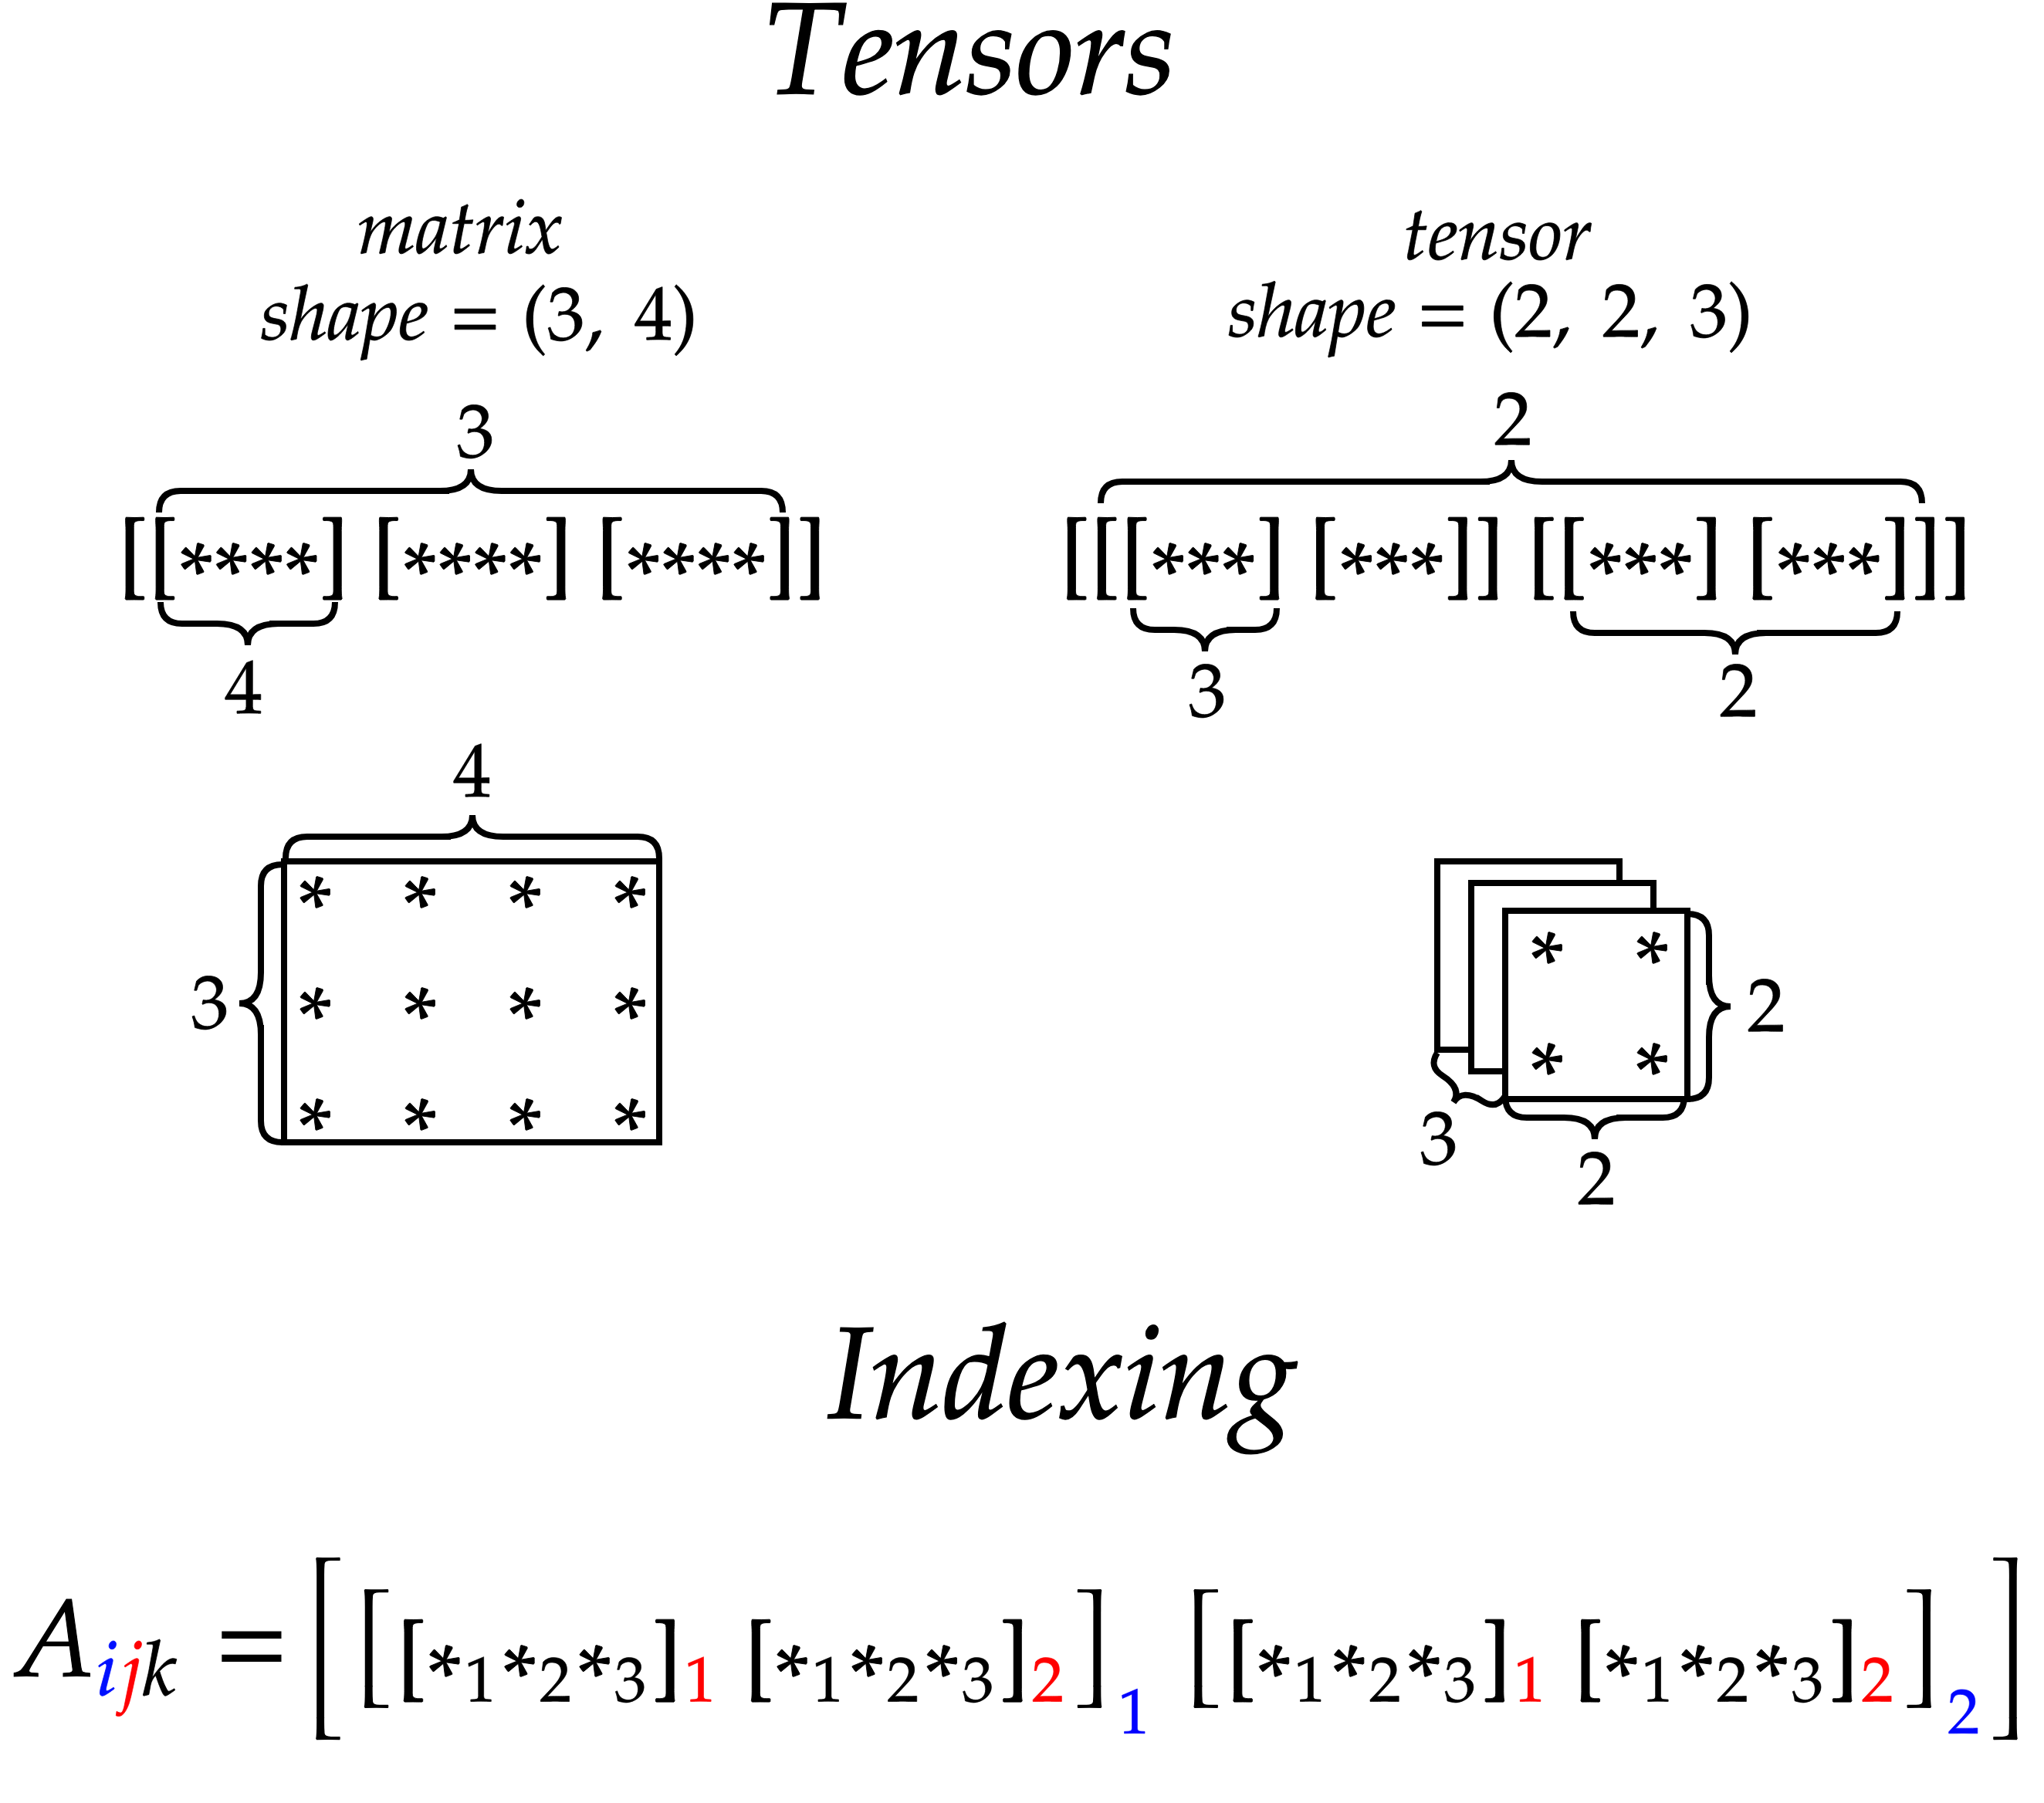

In [0]:
Image('tensors.png', width=600)

### Reshape and transpose

In [0]:
D = tf.random.normal((7, 6, 5), dtype=tf.float32, name='D')

print(tf.reshape(D, (7, 3, 2, 5), name='reshape_1').shape)
print(tf.reshape(D, (10, 21), name='reshape_2').shape)

print(tf.transpose(D, (2, 1, 0), name='transpose').shape)

### Indexing and slices

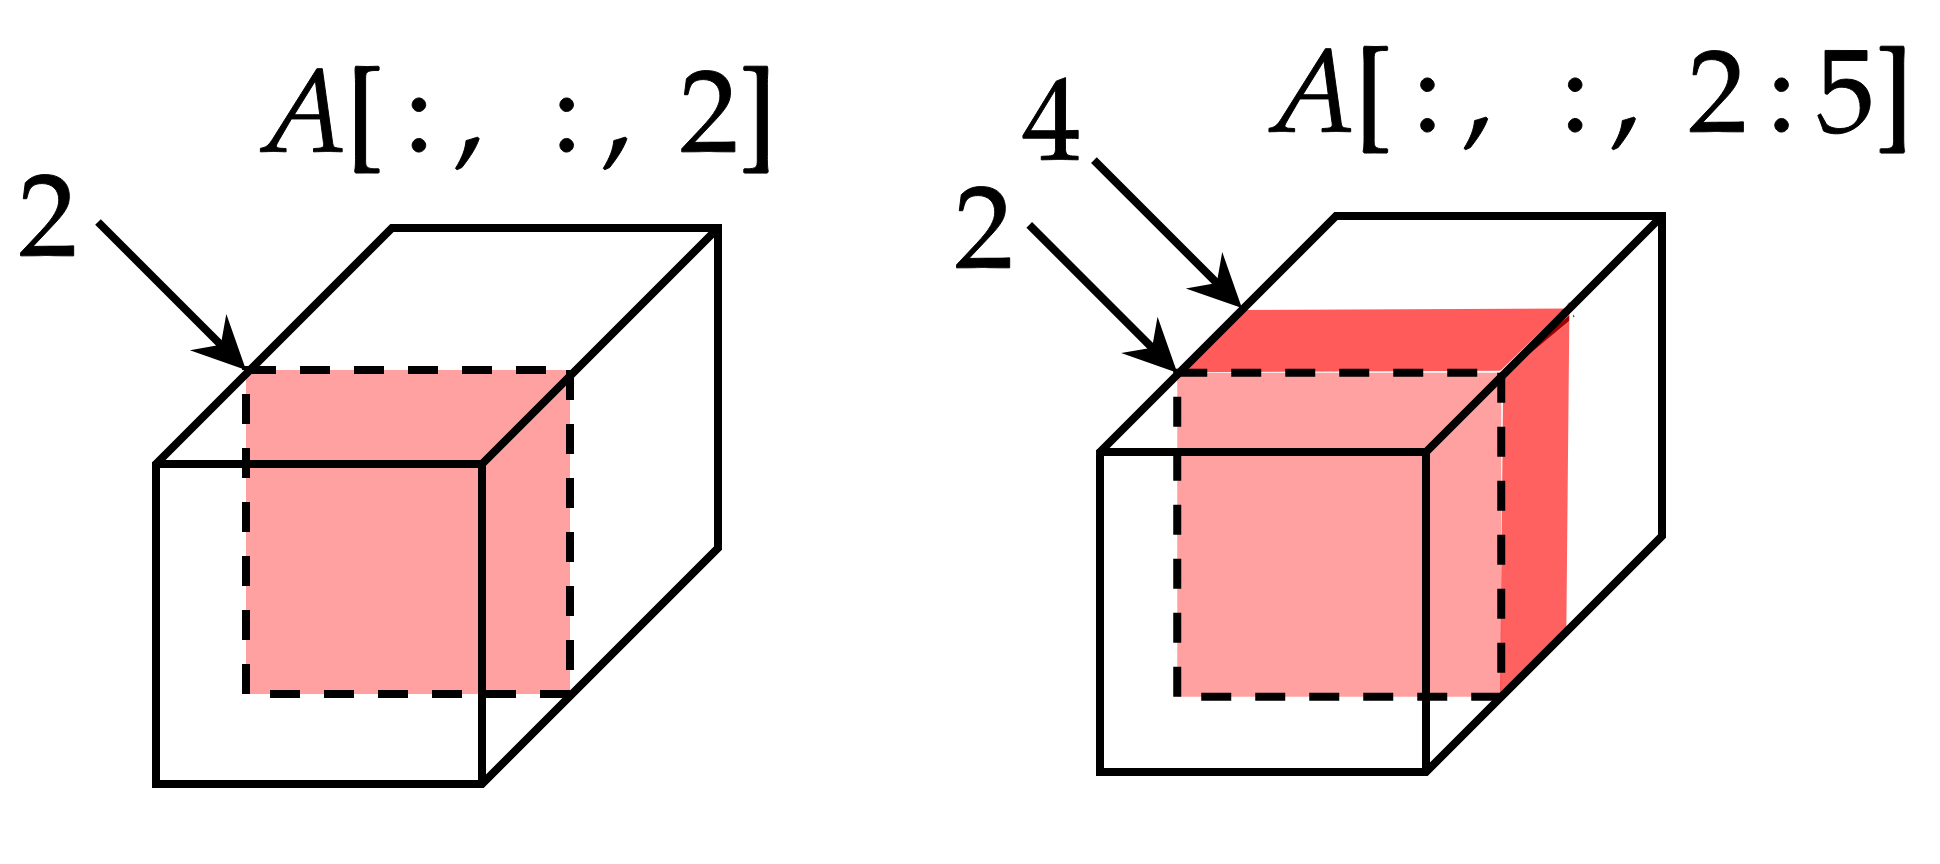

In [0]:
Image('slices.png', width=600)

In [0]:
print(D[:, :, 0].shape)
print(D[:, 2:5].shape)
print(D[:, :-2].shape)
print(D[:, :-2].shape)
print(D[..., :2].shape)
print(D[:, tf.newaxis, :].shape)

### Different operations over tensors

In [0]:
# element-wise operations

A = tf.reshape(tf.constant([1, 2, 3, 4, 5, 6, 7, 8], dtype=tf.float32, name='A'), (2, 2, 2), name='reshape')

print(tf.sqrt(A))
print(A ** 3)
print(tf.math.log(A))
print(tf.exp(A))

# etc

In [0]:
# operations which change the shape of a tensor

print(tf.reduce_mean(A, axis=2, keepdims=True, name='mean'))
print(tf.reduce_sum(A, axis=2, keepdims=True, name='sum'))
print(tf.reduce_max(A, axis=2, keepdims=True, name='max'))
print(tf.reduce_prod(A, axis=2, keepdims=True, name='prod'))
print(tf.tile(A, (3, 1, 1)).shape)

# etc

In [0]:
# different kinds of convalutions

A = tf.reshape(tf.constant([1, 2, 3, 4, 5, 6, 7, 8], dtype=tf.float32, name='A'), (2, 4), name='reshape_1')
B = tf.reshape(tf.constant([1, 2, 3, 4, 5, 6, 7, 8], dtype=tf.float32, name='B'), (4, 2), name='reshape_2')
C = tf.reshape(tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype=tf.float32, name='C'), (2, 2, 3), name='reshape_3')
D = tf.reshape(tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype=tf.float32, name='D'), (2, 3, 2), name='reshape_4')

print((A @ B).shape)
print(tf.einsum('ijk,ilj->kl', C, D).shape)

# etc

In [0]:
# linear algebra
A = tf.reshape(tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=tf.float32, name='A'), (3, 3), name='reshape')

exp_a = tf.linalg.expm(A)
U, S, V_h = tf.linalg.svd(A)
Q, R = tf.linalg.qr(A)

# and many many more

In [0]:
# element-wise summation, multiplication, power, etc

A = tf.reshape(tf.constant([1, 2, 3, 4, 5, 6, 7, 8], dtype=tf.float32, name='A'), (2, 2, 2), name='reshape')
B = tf.reshape(tf.constant([8, 7, 6, 5, 4, 3, 2, 1], dtype=tf.float32, name='A'), (2, 2, 2), name='reshape')

print(A + B)
print(A * B)
print(A ** B)

### Broadcasting

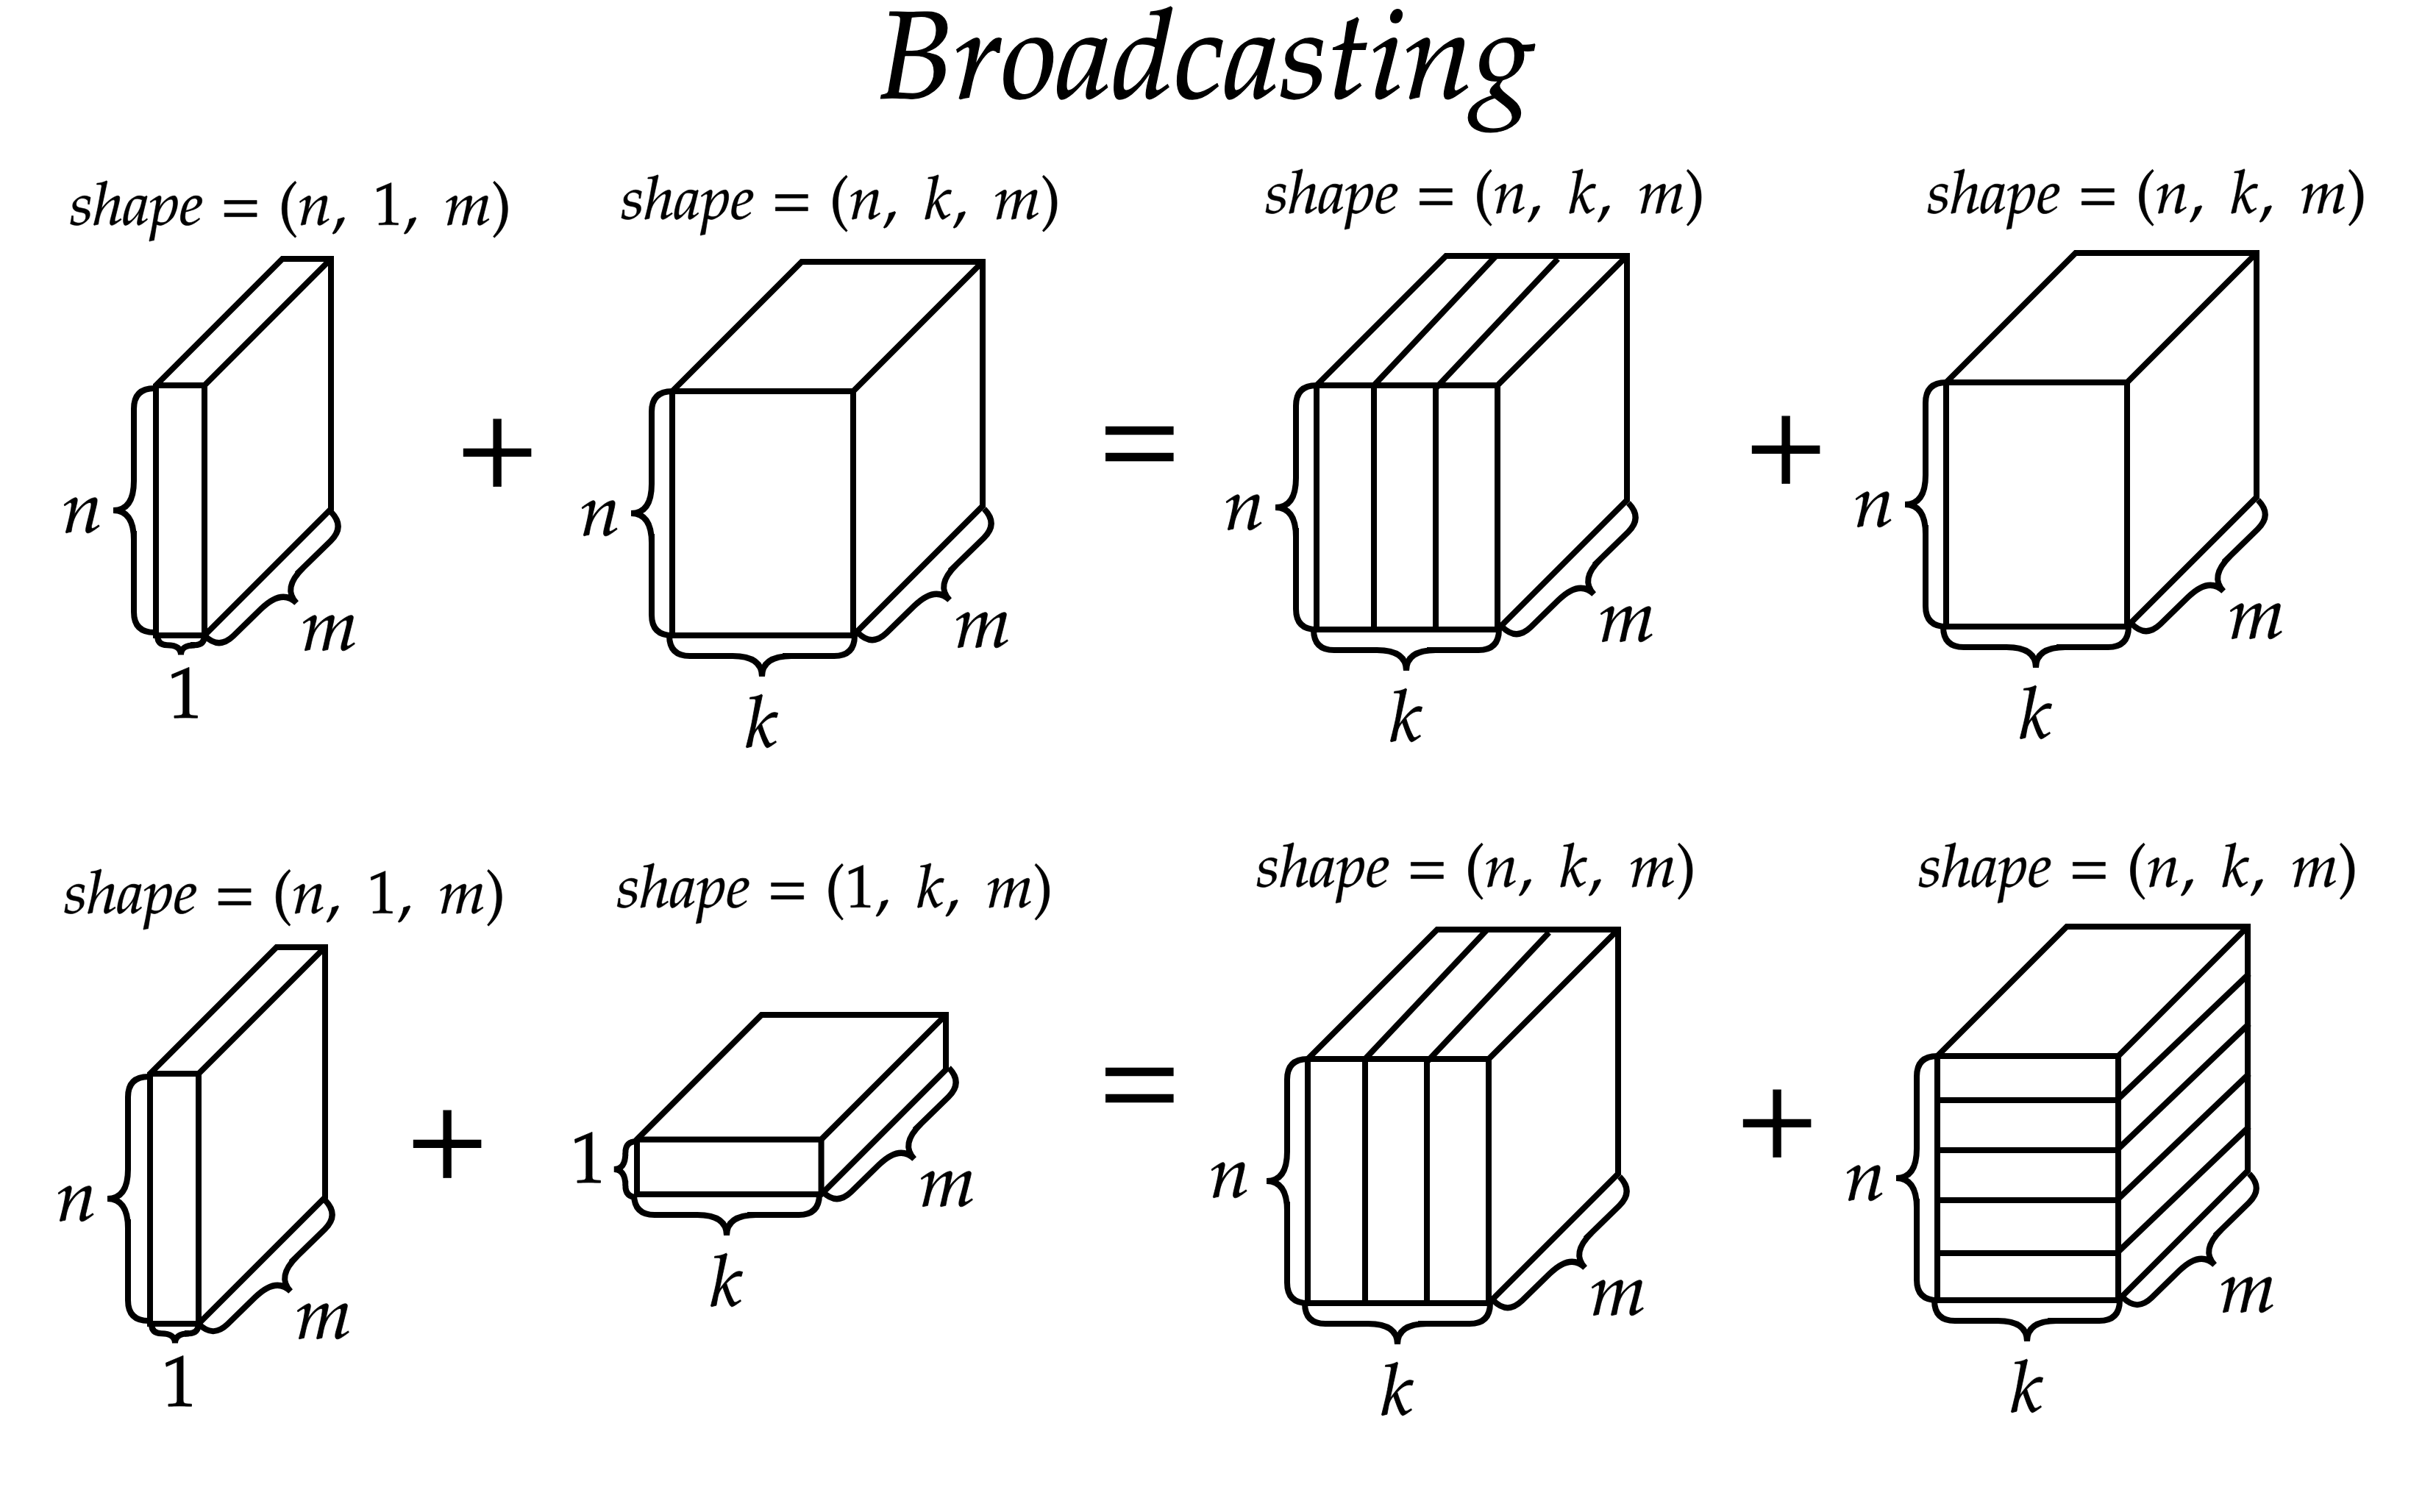

In [0]:
Image('broadcasting.png', width=800)

In [0]:
A = tf.random.normal((1, 2, 3, 4, 1), dtype=tf.float32, name='A')
B = tf.random.normal((1, 2, 1, 4, 5), dtype=tf.float32, name='B')
print((A + B).shape)
print((A * B).shape)
print((A ** B).shape)

### Tensors and NumPy

In [0]:
A = np.array([1, 2, 3, 4, 5], dtype=np.float32)
A = tf.constant(A)
print(A)
A = A.numpy()
A

### Variables

In [0]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]], dtype=tf.float32)
v.assign(2 * v)
print(v)
v[0, 1].assign(42)
print(v)

### Autodiff

In [0]:
# two variables and one constant
v1 = tf.Variable([1, 2, 3, 4, 5, 6, 7, 8], dtype=tf.float32)
v2 = tf.Variable([1, 2, 3, 4, 5, 6, 7, 8], dtype=tf.float32)
A = tf.constant([1, 2, 3, 4], dtype=tf.float32)

# making some convolution of all three objects to scalar
with tf.GradientTape() as tape:
    v1_resh = tf.reshape(v1, (2, 2, 2))
    v2_resh = tf.reshape(v2, (2, 2, 2))
    A_resh = tf.reshape(A, (2, 2))
    B = tf.einsum('ijk,kl,lmn->ijmn', v1_resh, A_resh, v2_resh)
    out = tf.linalg.trace(tf.reshape(B, (4, 4)))

# gradient d_out / d_v1 and d_out / d_v2    
tape.gradient([out], [v1, v2])

# The example: learning of laser dynamics by using recurrent neural network

### Mean field laser equation

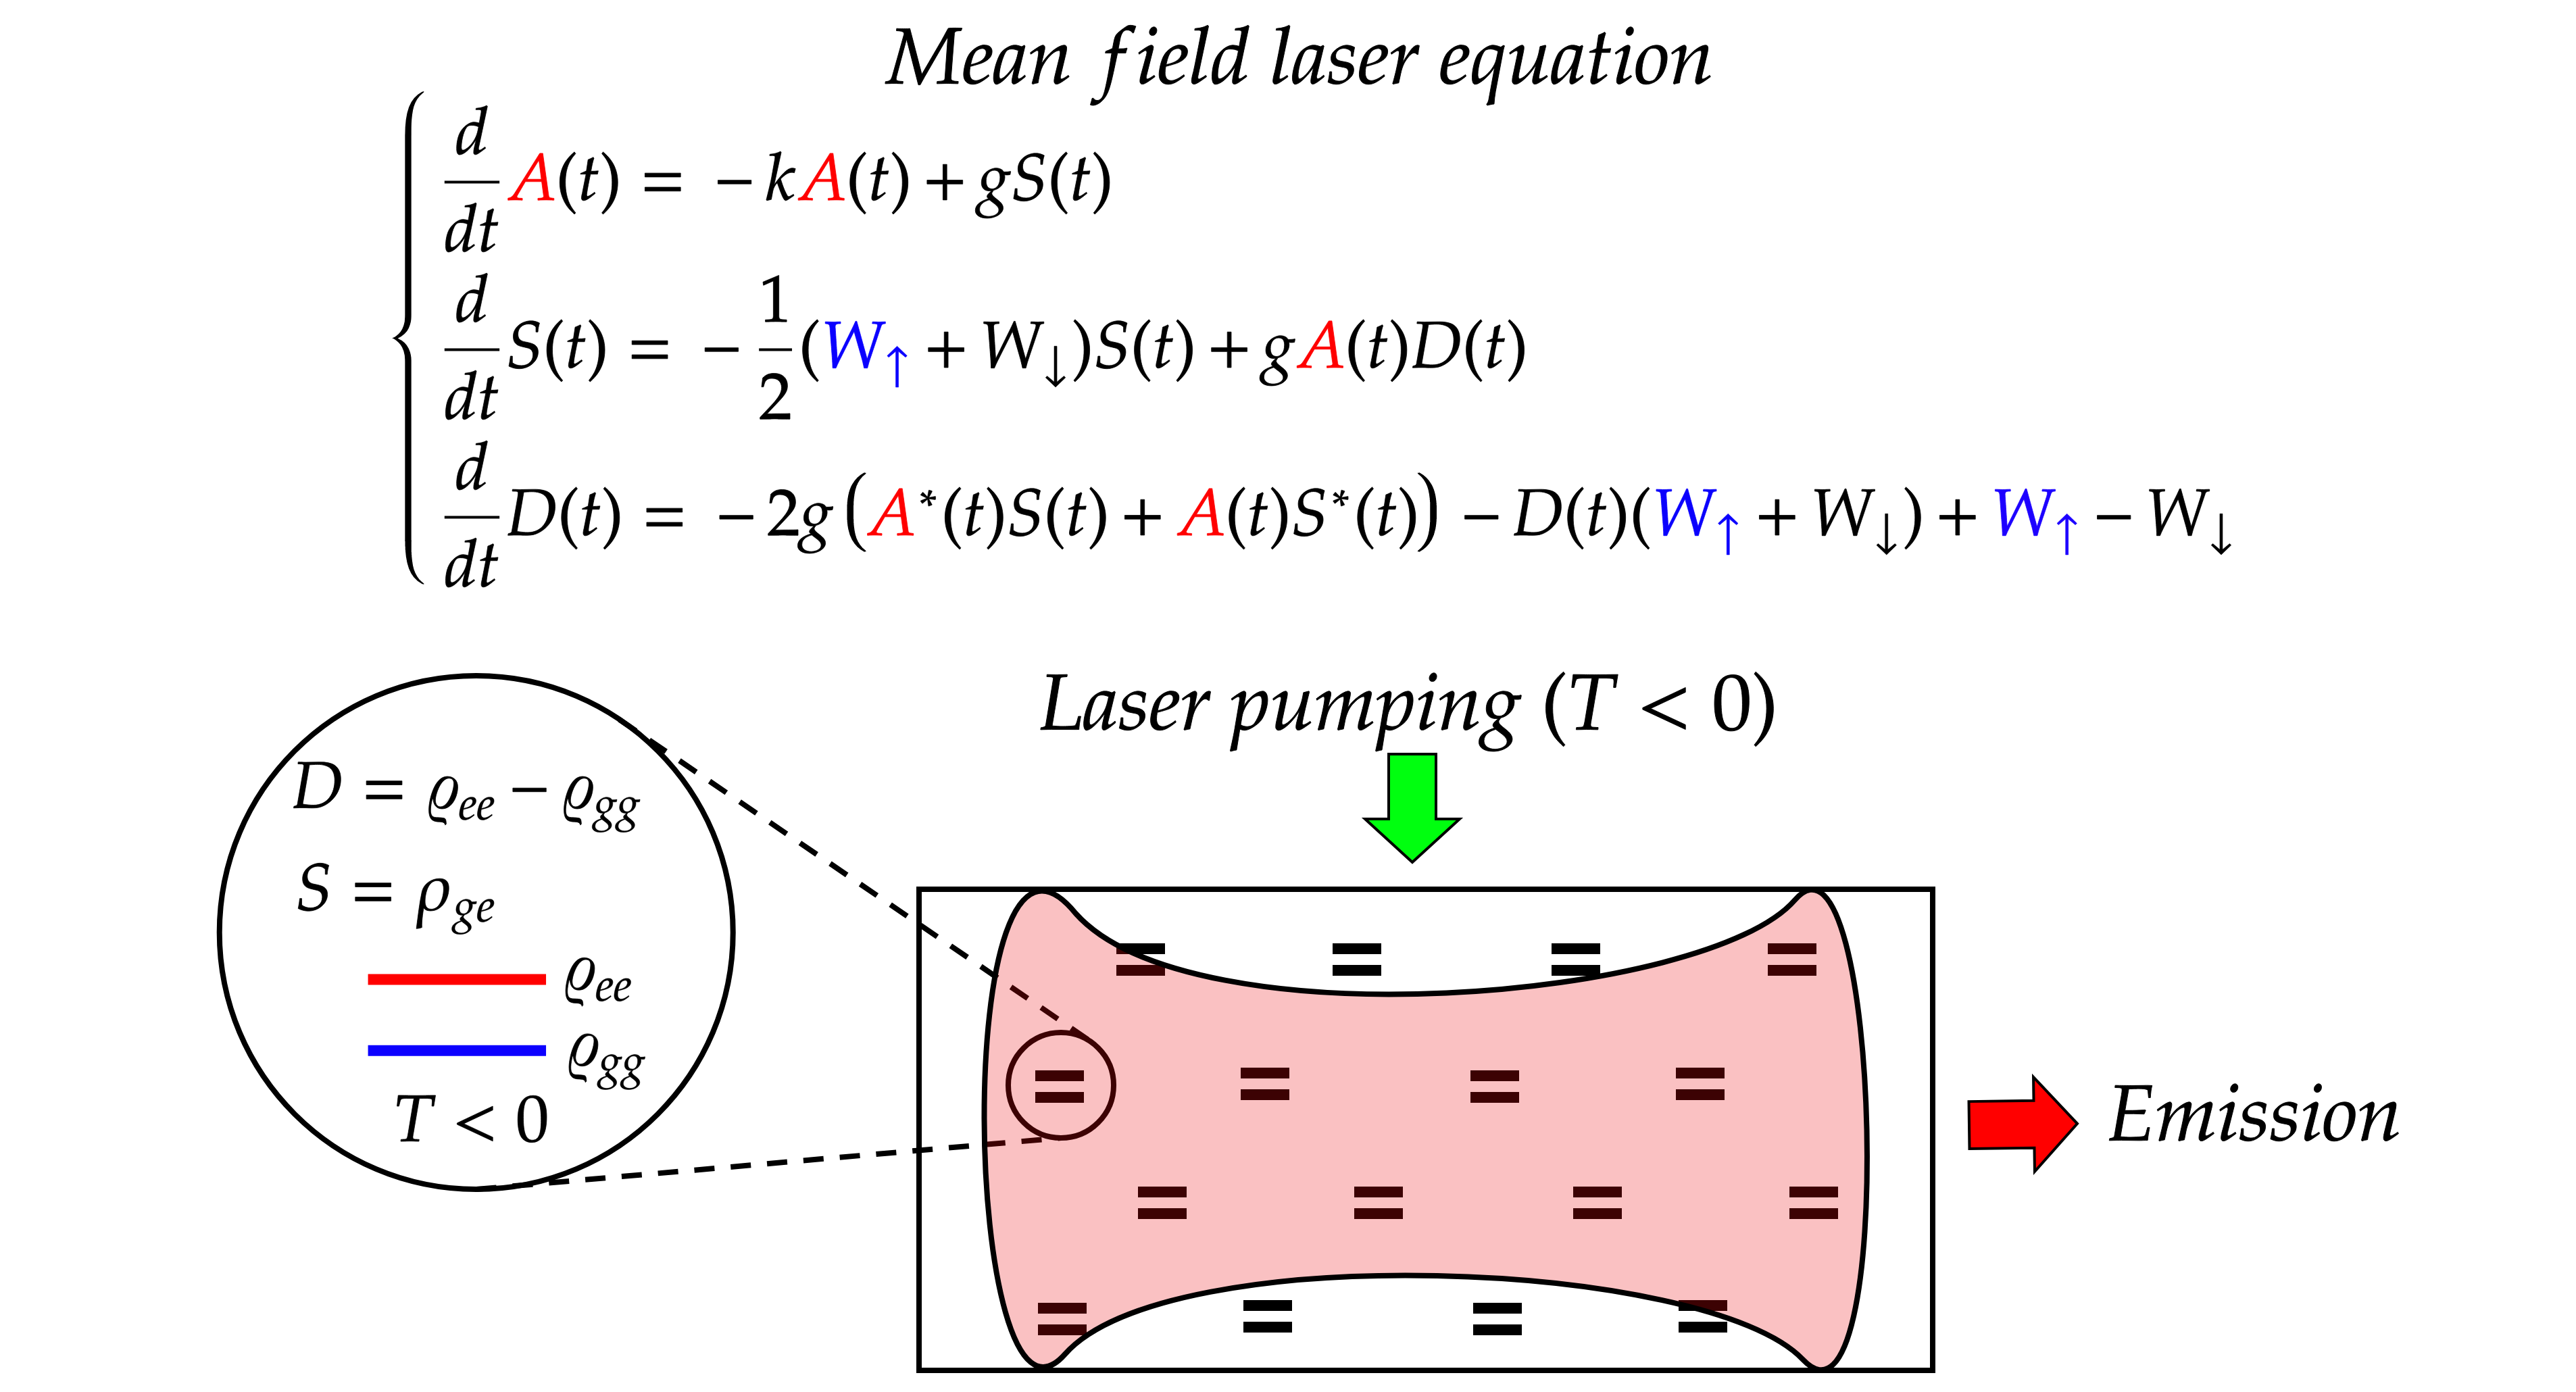

In [0]:
Image('Mean_field_laser.png', width=1000)

### RNN: a training stage

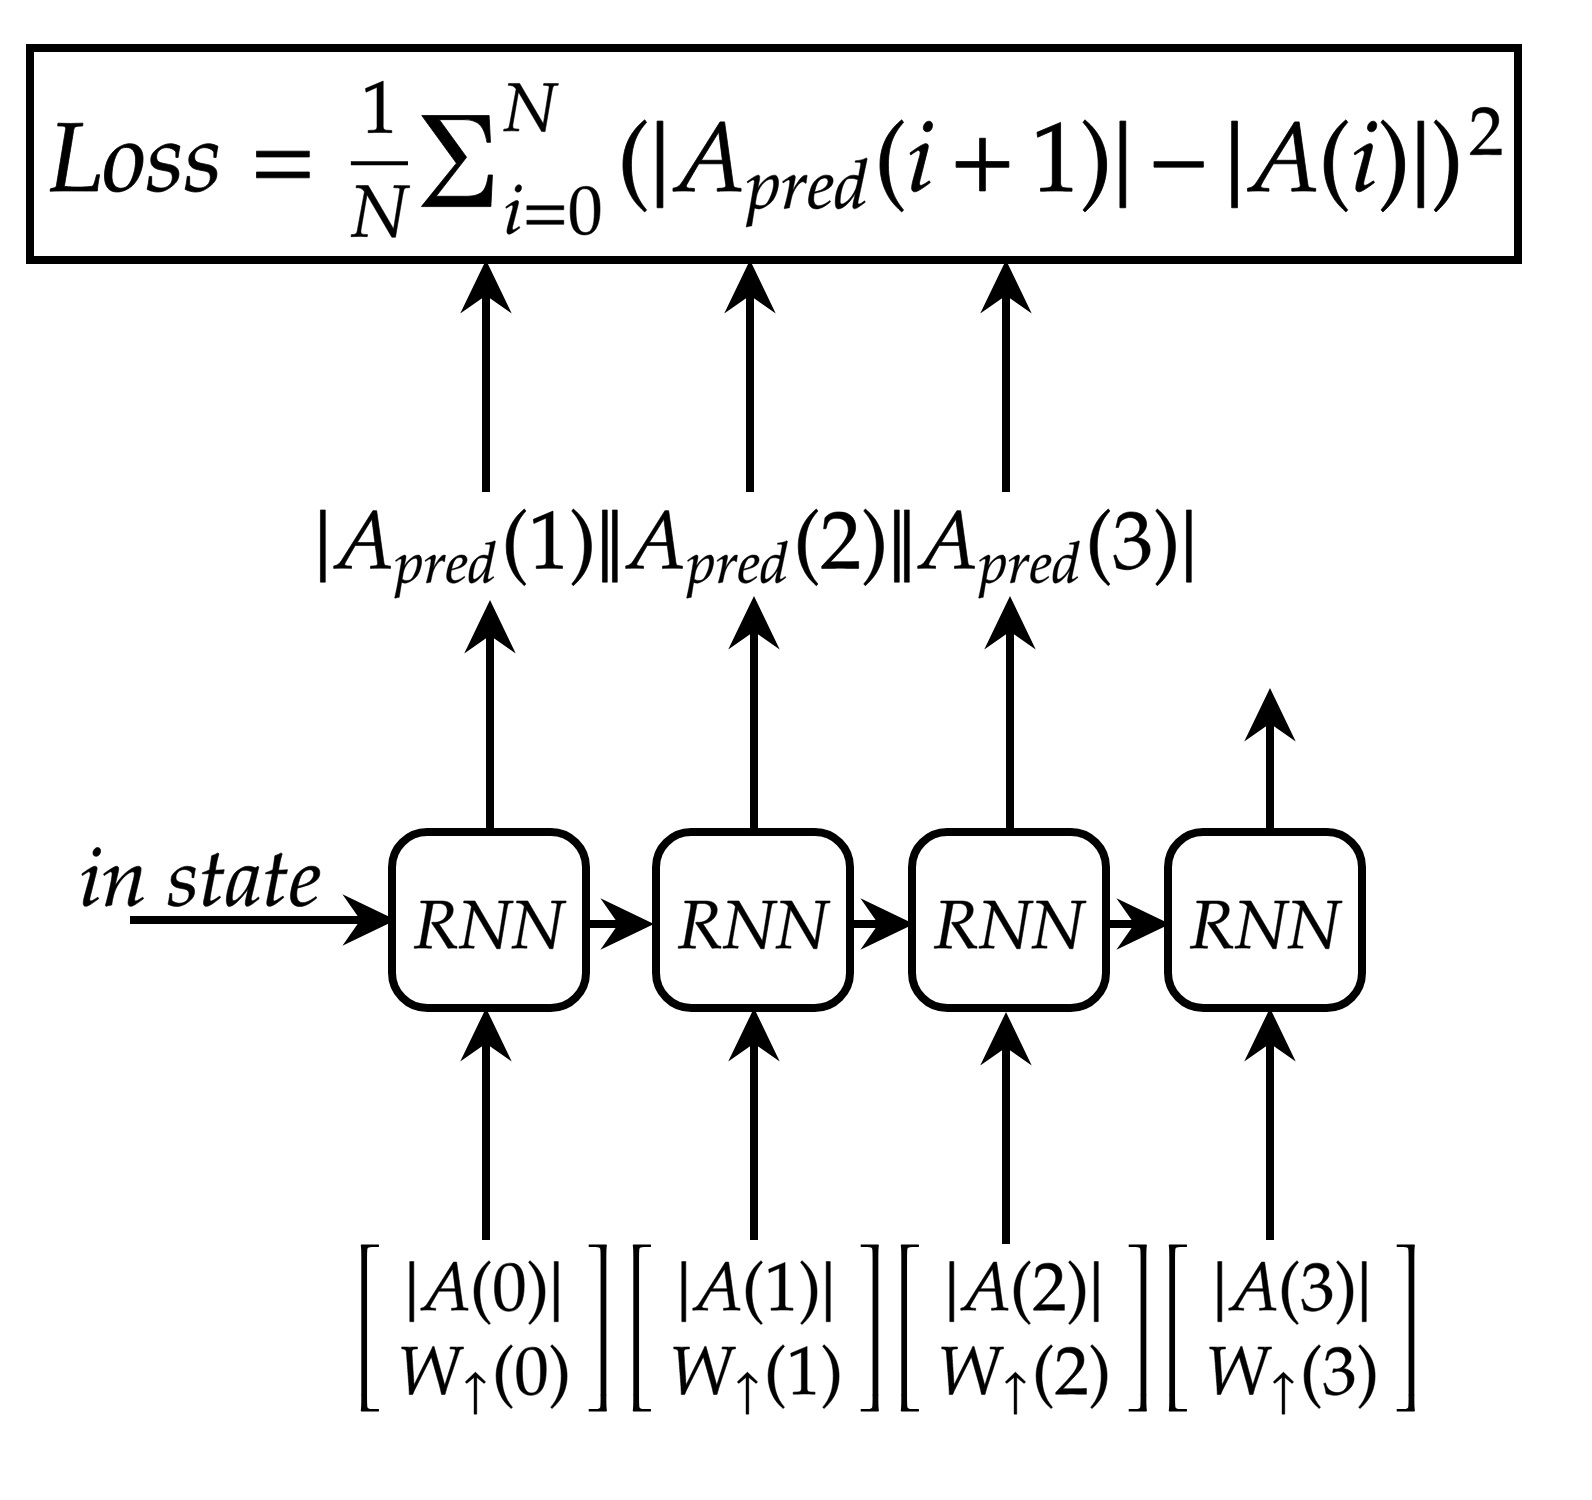

In [0]:
Image('rnn_train.png', width=600)

### RNN: an inference stage

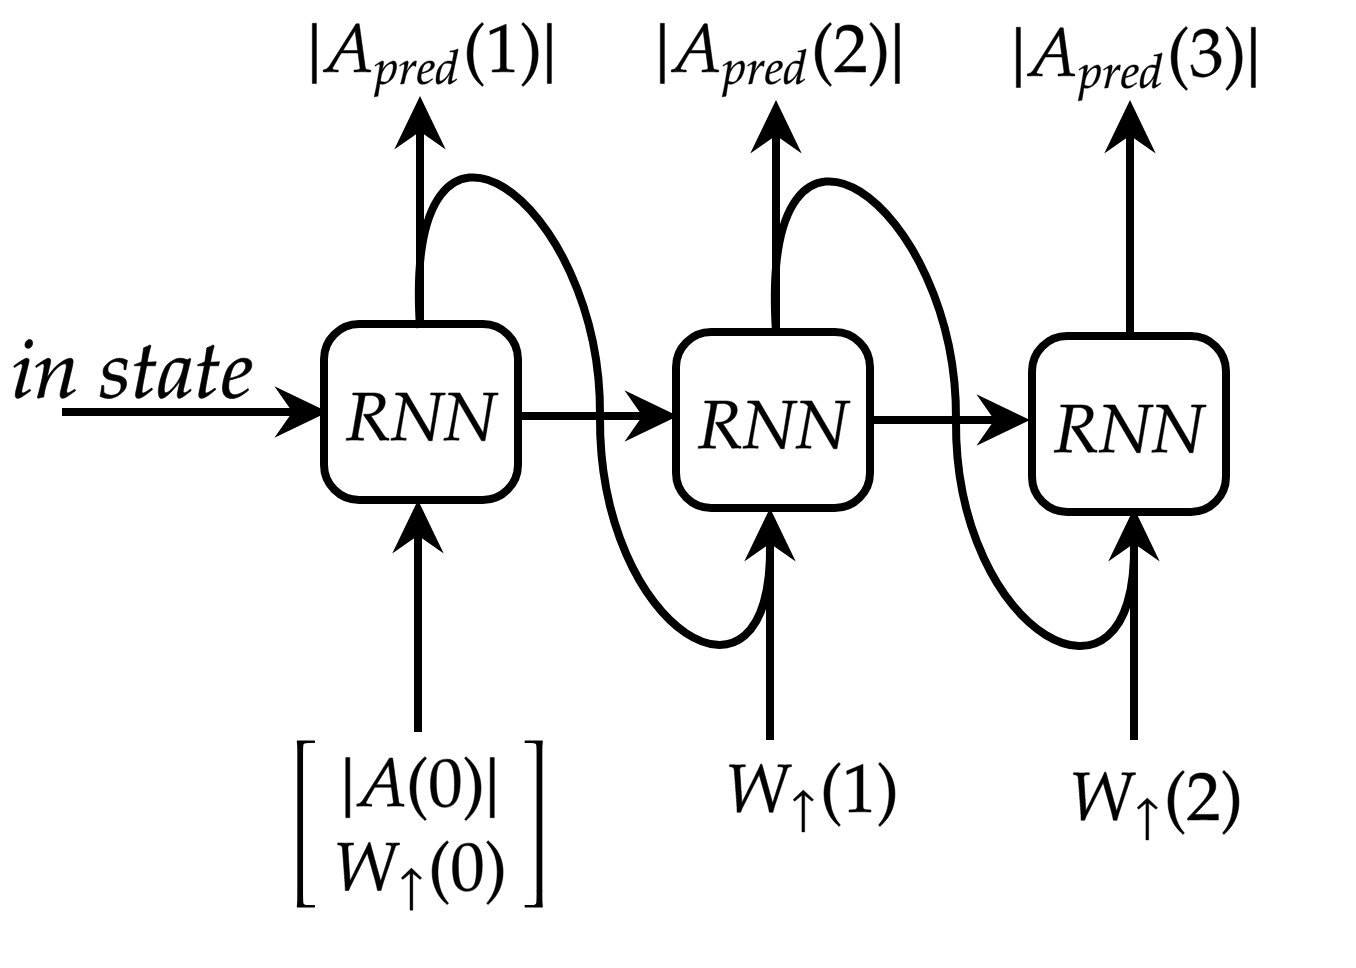

In [0]:
Image('rnn_pred.png', width=600)

### Here we set parameters of the model and define a function which implements the Euler method

In [0]:
##########################
# parameters of the model#
##########################
##########################
# number of experiments
num_of_exp = 100
# length of simulation
length_of_session = 3000
# time step
dt = 0.03

# the decay rate of the laser model
k = tf.constant(0.1, dtype=tf.float32)
# coupling
g = tf.constant(1, dtype=tf.float32)
# the decay rate of the TLC
W_down = tf.constant(0.1, dtype=tf.float32)
# "steady" controll signall
W_steady = 0.5
##################################
##################################

#####################################################
# controllable parameters (setting random sequence) #
#####################################################

# filling random signal
W_up = np.zeros((num_of_exp * length_of_session,), dtype=np.complex64)
idx = np.random.randint(low=1, high=num_of_exp * length_of_session -1,\
                        size=(int(num_of_exp * length_of_session / 100),))
idx.sort()
for i in range(idx.shape[0]):
    W_up[idx[i]:] = np.random.uniform(high=2)

W_up = np.reshape(W_up, (num_of_exp, length_of_session))
W_up[:, :300] = W_steady
W_up = tf.constant(W_up)


###################
# update function #
###################
@tf.function
def time_step(X, W_up, dt=0.03, k=0.1, g=1, W_down=0.1):
    
    # update for A
    A_new = (-k * X[:, 0] + g * X[:, 1]) * dt + X[:, 0]
    
    # update for S
    S_new = (-(0.5 * (W_up + W_down)) * X[:, 1] + g * X[:, 0] * X[:, 2]) * dt + X[:, 1]
    
    # update for D
    D_new = (-2 * g * (tf.math.conj(X[:, 0]) * X[:, 1] + X[:, 0] * tf.math.conj(X[:, 1])) -\
    (W_up + W_down) * X[:, 2] + (W_up - W_down)) * dt + X[:, 2]
    
    return tf.concat([A_new[..., tf.newaxis], S_new[..., tf.newaxis],\
               D_new[..., tf.newaxis]], axis=-1)

### Here we find steady-state (will be the initial state of each experiment)

In [0]:
X_in = tf.random.uniform((1, 3))
for i in range(5000):
    X_in = time_step(X_in, W_steady, dt=dt, k=k, g=g, W_down=W_down)
X = tf.cast(tf.tile(X_in, (num_of_exp, 1)), dtype=tf.complex64)

### Dataset generation (Laser dynamics)

In [0]:
##################################
##################################
# level of noise
l_of_noise = 0.03
##################################
##################################

# the list will be filled by time slices of dynamics
list_of_Ampl = []

# main loop
for i in range(3000):
    X = time_step(X, W_up[:, i])
    list_of_Ampl.append(tf.math.abs(X[:, 0]).numpy())

# data set (deletion of intermediate points and adding noise)
list_of_Ampl = np.array(list_of_Ampl).transpose((1, 0))
list_of_Ampl_reduced = list_of_Ampl[:, ::10] + l_of_noise * np.random.randn(*list_of_Ampl[:, ::10].shape)
W_up_reduced = tf.cast(W_up[:, ::10], dtype=tf.float32)

### An example of dynamics under random control

In [0]:
# example of dynamics
dyn = list_of_Ampl[10]
reduced_dyn = list_of_Ampl_reduced[10]

# plotting
trace1 = go.Scatter(
    
    x = np.arange(0, dyn.shape[0] * dt, dt),
    y = dyn,
    name='dynamics',
    line = dict(
        color = ("blue"),
        width = 2
    )
) 

trace2 = go.Scatter(
    
    x = np.arange(0, reduced_dyn.shape[0] * dt * 10, dt * 10),
    y = reduced_dyn,
    name='reduced dynamics',
    line = dict(
        color = ("red"),
        width = 2
    )
) 

trace3 = go.Scatter(
    
    x = np.arange(0, W_up[10].shape[0] * dt, dt),
    y = tf.cast(W_up[10], dtype=tf.float32),
    name='control signal',
    line = dict(
        color = ("blue"),
        width = 1,
        dash='dash'
    )
) 

trace4 = go.Scatter(
    
    x = np.arange(0, W_up_reduced[10].shape[0] * dt * 10, dt * 10),
    y = tf.cast(W_up_reduced[10], dtype=tf.float32),
    name='control signal reduced',
    line = dict(
        color = ("red"),
        width = 1,
        dash='dash'
    )
) 
    

layout = dict(
    xaxis = dict(title=r'$time$',
        ticks="outside",
        tickwidth=2,
        tickcolor='black',
        ticklen=10,
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        titlefont=dict(
                size=18, 
                color='black'
            )
                ),
    yaxis = dict(ticks="outside",
        title=r'$A$',
        tickwidth=2,
        tickcolor='black',
        ticklen=10,
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        titlefont=dict(
        size=18, 
        color='black'
            )
                ),
        legend=go.layout.Legend(
        x=0.8,
        y=1,),
        width=1000,
        height=500)

data = [trace1, trace2, trace3, trace4]

fig = go.Figure(data, layout)

fig.show()

### RNN and loss function

In [0]:
##################################
##################################
# size of state
hidd_dim = 16
# size of intermediate dens layer
dens_dim = 16
##################################
##################################

# initial state of RNN
initial_state = tf.constant(tf.random.normal((1, hidd_dim)), dtype=tf.float32)

# GRU cell
gru = tf.keras.layers.GRU(units=hidd_dim, input_shape=(None, 2), reset_after=True, use_bias=True,\
      return_sequences=True)

# two dens layers
inp = tf.keras.layers.Input((None, hidd_dim), dtype=tf.float32)
x = tf.keras.layers.Dense(dens_dim, activation='elu', kernel_initializer='he_normal')(inp)
out = tf.keras.layers.Dense(1, activation=None, kernel_initializer='he_normal')(x)
dens = tf.keras.Model(inputs=inp, outputs=out)

# loss function
@tf.function
def loss(data, gru, dens, initial_state):
    
    gru_out = gru(data, initial_state=initial_state)
    prediction = dens(gru_out)[:, :-1, 0]
    
    return tf.reduce_mean((prediction\
                           - data[:, 1:, 0]) ** 2)

### Training

In [0]:
# concatenation of W and A to the tensor (dataset) of shape (batch_size, num_of_steps, 2)
data_in = tf.concat([list_of_Ampl_reduced[..., tf.newaxis],\
                     W_up_reduced[..., tf.newaxis]], axis=-1)

# optimizer
opt = tf.optimizers.Nadam(0.001)

# the list will be filled by values of loss
losses = []

# training loop
for _ in range(1000):
    with tf.GradientTape() as tape:
        
        initial_states = tf.tile(initial_state, (num_of_exp, 1))

        l = loss(data_in, gru, dens, initial_states)
    
    # gradient
    grad = tape.gradient(l, gru.weights + dens.weights)
    
    # opt step
    opt.apply_gradients(zip(grad, gru.weights + dens.weights))
    losses.append(l)

### Plotting of loss function

tf.Tensor(0.0016705131, shape=(), dtype=float32)


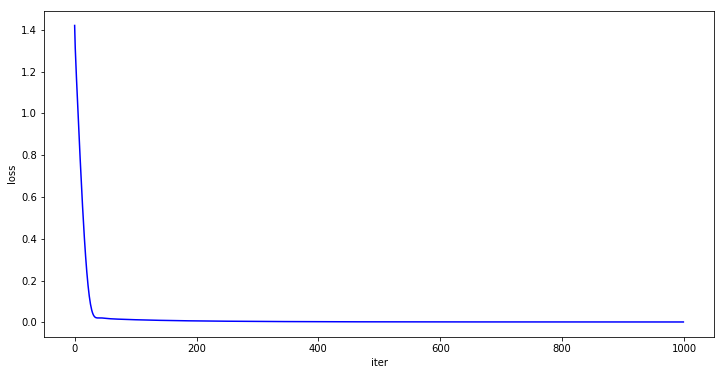

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(losses, 'b')
plt.ylabel('loss')
plt.xlabel('iter')
print(losses[-1])

### Here we define a function, which makes a prediction based on trained RNN.

In [0]:
def prediction(in_A, in_W_up, state, gru, dens):
    
    inp = tf.concat([tf.reshape(in_A, (1, 1, 1)), tf.reshape(in_W_up, (1, 1, 1))], axis=-1)
    state_new = gru(inp, initial_state=state)
    A_new = dens(state_new)
    return A_new[0, 0, 0], state_new[0]

### Here we define the control signal, which will be used for validation.

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 0, 'time')

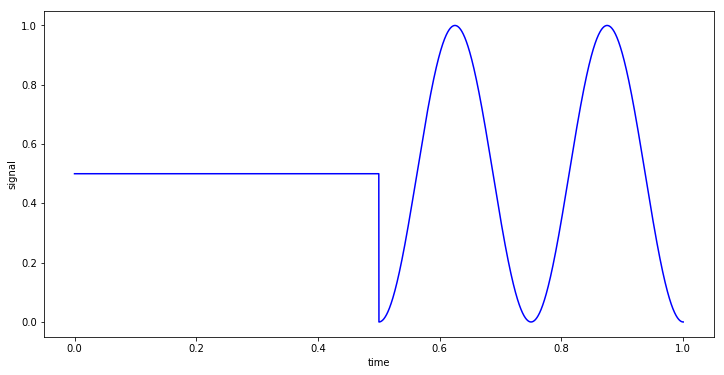

In [0]:
# controll signal
in_W_up = np.linspace(0, 4 * np.pi, 4000, dtype=np.float32)
in_W_up = np.sin(in_W_up) ** 2
in_W_up[:2000] = W_steady

in_W_up_reduced = in_W_up[::10]
in_W_up = tf.cast(in_W_up, dtype=tf.complex64)

# plotting of signal
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, 1, 4000), in_W_up, 'b')
plt.ylabel('signal')
plt.xlabel('time')

### Evaluating the learned dynamics

In [0]:
# initial amplitude of field
in_A = X_in[0, 0]

# initial state of RNN
in_state = initial_state

# the list will be filled by values of Ampl.
set_of_Ampl_learned = []

# main loop
for i in range(400):
    set_of_Ampl_learned.append(in_A)
    in_A, in_state = prediction(in_A, in_W_up_reduced[i], in_state, gru, dens)

# "X" and "Y" for plotting
set_of_Ampl_learned = np.array(set_of_Ampl_learned)
times_learned = np.linspace(0, 1, set_of_Ampl_learned.shape[0])

### Evaluating the true dynamics

In [0]:
# the list will be filled by values of Ampl.
set_of_Ampl_true = []

# initial amplitude of field
A_in = tf.cast(X_in, dtype=tf.complex64)

# main loop
for i in range(4000):
    A_in = time_step(A_in, tf.cast(in_W_up[i], dtype=tf.complex64))
    set_of_Ampl_true.append(tf.math.abs(A_in[:, 0]).numpy())
    
# "X" and "Y" for plotting
set_of_Ampl_true = np.array(set_of_Ampl_true)[:, 0]
times_true = np.linspace(0, 1, set_of_Ampl_true.shape[0])

### Plotting of true vs. learned dynamics

In [0]:
# plotting
trace1 = go.Scatter(
    
    x = times_true,
    y = set_of_Ampl_true,
    name='true dynamics',
    line = dict(
        color = ("blue"),
        width = 2
    )
) 

trace2 = go.Scatter(
    
    x = times_learned,
    y = set_of_Ampl_learned,
    name='learned dynamics',
    line = dict(
        color = ("red"),
        width = 2
    )
) 
    

layout = dict(
    xaxis = dict(title=r'$time$',
        ticks="outside",
        tickwidth=2,
        tickcolor='black',
        ticklen=10,
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        titlefont=dict(
                size=18, 
                color='black'
            )
                ),
    yaxis = dict(ticks="outside",
        title=r'$A$',
        tickwidth=2,
        tickcolor='black',
        ticklen=10,
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        titlefont=dict(
        size=18, 
        color='black'
            )
                ),
        legend=go.layout.Legend(
        x=0.8,
        y=1,),
        width=1000,
        height=500)

data = [trace1, trace2]

fig = go.Figure(data, layout)

fig.show()